# Michael Sepe: Federal Reserve Bank Atlanta Coding Challenge Response
# 08/21/23

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from pmdarima import auto_arima
from scipy.signal import butter, filtfilt
from scipy.stats import pearsonr

## Question 1:

 Unsupervised + supervised learning.
--------------------------------------

Attached is a data file dataClustering.csv which contains a data set of 2500 samples
with 8 features. 
i) Perform any clustering of your choice to determine the optimal # of clusters in the data
ii) Using the result of i) assign clusters labels to each sample, so each sample's label is the
cluster to which it belongs. Using these labels as the exact labels, you now have a labeled dataset.
Build a classification model that classifies a sample with its corresponding label. Use multinomial 
regression as a benchmark model, and any ML model (trees, forests, SVM, NN etc.) as a comparison model.
Comment on which does better and why.

i)

In [2]:
# Loading in the clustering data
q1 = pd.read_csv('/Users/mikesepe/Downloads/quant_spec_coding/data/dataClustering.csv', header = None)
q1.head()

,0,1,2,3,4,5,6,7
0,5.640720,9.180183,10.288661,7.621833,5.129126,-10.199154,0.366043,9.132704
1,7.962137,4.390779,6.513514,5.391677,7.692616,-7.506085,-0.565842,10.024006
2,-0.299819,-3.566931,-5.836508,-4.744202,-1.569449,-4.212983,6.049983,-10.130941
3,3.744348,5.615159,8.551187,5.847903,4.274492,-7.364897,-2.982627,9.771248
4,1.013368,5.062748,0.445446,0.893973,-9.631507,-10.597874,9.043212,-5.625417


In [3]:
# Append to empty list
interia_list = []

for i in range(1,8):
    # Starting clustering for each 
    kmeans = KMeans(n_clusters=i, random_state=1776)
    kmeans.fit(q1)
    interia_list.append(kmeans.inertia_)

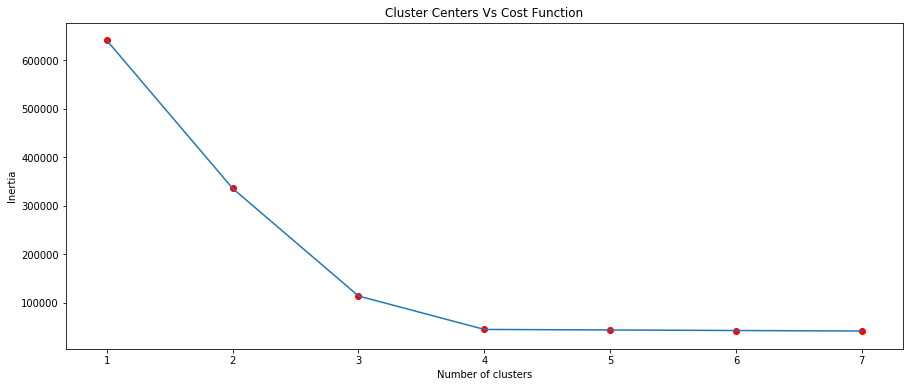

In [39]:
plt.figure(figsize = (15,6))
plt.plot(range(1, 8), interia_list)
plt.scatter(range(1,8), interia_list, color = 'r')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Cluster Centers Vs Cost Function')
plt.show()

### ANSWER: Here I am observing the elbow plot to identify the number of clusters in which there is diminishing returns to enforcing another cluster. Upon inspection I have decided to implement 4 clusters based on the minimal reduction in cost function with increasing cluster amount to greater than 4.

ii)

In [5]:
# Define the optimal amount
optimal_cluster_amount = 4

# Creating a kmeans with the optimal cluster amount
k_means = KMeans(n_clusters = optimal_cluster_amount,
                random_state = 1776)

# Assigning the labels to a variabl in the df
q1['label'] = k_means.fit_predict(q1)


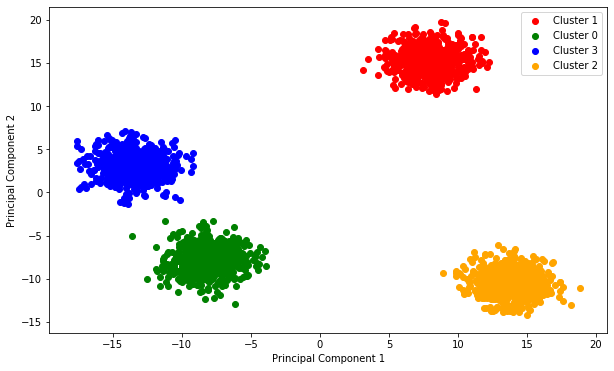

In [6]:
# Perform PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(q1.drop('label', axis=1))

# Create a new DataFrame with the principal components and cluster labels
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['Cluster'] = q1['label']

# Get the unique cluster labels
unique_clusters = pc_df['Cluster'].unique()

# Plot the 2D PCA visualization
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'black']
for i, cluster in enumerate(unique_clusters):
    plt.scatter(pc_df[pc_df['Cluster'] == cluster]['PC1'],
                pc_df[pc_df['Cluster'] == cluster]['PC2'],
                color=colors[i % len(colors)],
                label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Here I am observing the first two principal components for each observation and displaying the cluster designation with color. It is very clear that the clusters are discernable with linear boundaries. This, in turn, will prove to be a reason why the multinomial logistic regression algorithm will perform well.

In [7]:
# Creating the x and y
X = q1.drop('label', axis=1)
y = q1['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1776)

# Initializing a multinomial model, fitting and predicting
model = LogisticRegression(multi_class='multinomial',
                            solver='lbfgs',
                            max_iter = 10_000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1 Score: 1.0


### The multinolial regression had 100% accuracy, this can be attributed to the ability to discern between clusters with linear boundaries.

In [8]:
# Define and fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1776)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_y_pred = rf_model.predict(X_test)

# Print the classification report
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Random Forest Classifier:")
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')



Random Forest Classifier:
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1 Score: 1.0


### Again there was a 100% accuracy, if there were non linear boundaries the random forrest classifier would be able to articulate to said boundaries, thus outperforming the logistic regression. But, in this case they both perform well at a perfect accuracy and F1 score.

## Question 2:

Prediction + filtering
--------------------------

Attached are 3 files: xvalsSine.csv, cleanSine.csv and noisySine.csv. xvalsSine.csv contains
1000 x-values in the interval -pi/2 to pi/2. cleanSine.csv is a pure sine(x) function for the
x values mentioned earlier. noisySine.csv contains sine(x) corrupted by noise. 
i) Using xvalsSine.csv and cleanSine.csv as a labeled dataset (x,sine(x)) being (value,label) with a
random train/test split of 0.7/0.3, build an OLS regression model (you may want to use polynomial
basis of a sufficiently large order). 
(bonus) If you used the normal equations to solve the OLS problem, can you redo it with stochastic
gradient descent?
ii) Now, assume you are given the noisySine.csv as a time series with the values of 
xvalsSine.csv being the time variable. Filter the noisySine.csv data with any filter of your choice
and compare against cleanSine.csv to report the error.
(bonus) Can you code a Kalman filter to predict out 10 samples from the noisySine.csv data?



In [24]:
# Importing data
cleansine = pd.read_csv('/Users/mikesepe/Downloads/quant_spec_coding/data/cleanSine.csv', header = None)
noisySine = pd.read_csv('/Users/mikesepe/Downloads/quant_spec_coding/data/noisySine.csv', header = None)
xvalsSine = pd.read_csv('/Users/mikesepe/Downloads/quant_spec_coding/data/xvalsSine.csv', header = None)


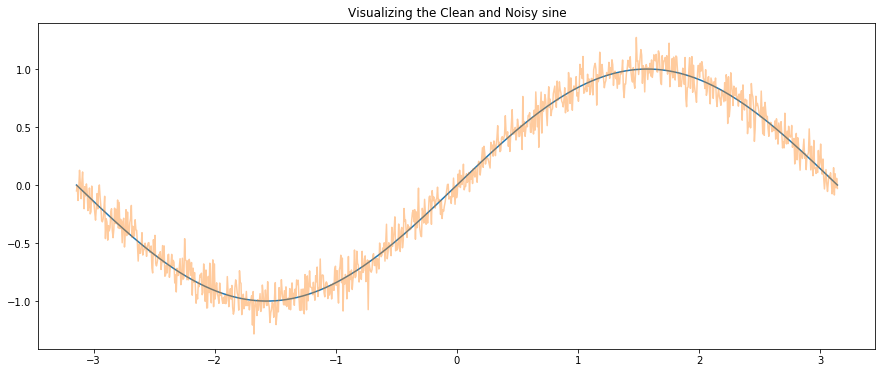

In [27]:
# Visualizing the data
plt.figure(figsize = (15,6))
plt.plot(xvalsSine, cleansine)
plt.plot(xvalsSine, noisySine, alpha = 0.4)
plt.title('Visualizing the Clean and Noisy sine')
plt.show()

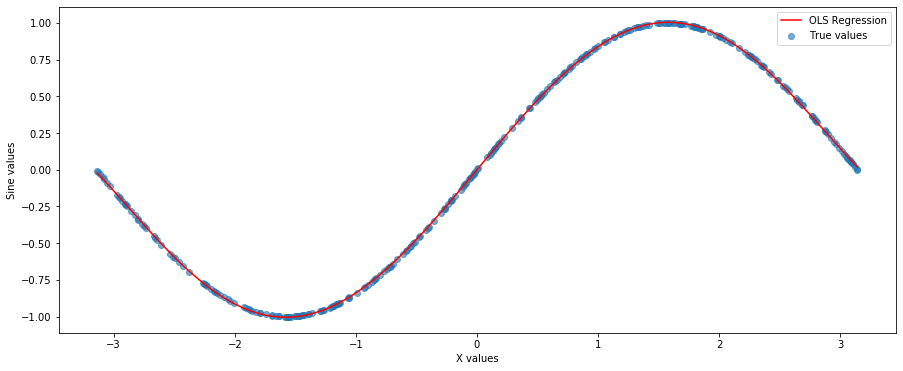

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(xvalsSine, cleansine, test_size=0.3, random_state=0)

# Create polynomial features
degree = 5 
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Build and train the OLS regression model
ols_model = LinearRegression()
ols_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = ols_model.predict(X_test_poly)

# Plot the results
plt.figure(figsize = (15,6))
plt.scatter(X_test, y_test, label='True values', alpha = 0.6)
plt.plot(sorted(X_test.values.flatten()), [pred for _, pred in sorted(zip(X_test.values.flatten(), y_pred))], color='red', label='OLS Regression', alpha = 1)
plt.title('Clean Sine approximated by Lin Regress')
plt.legend()
plt.show()


### Trying with stochastic gradient descent

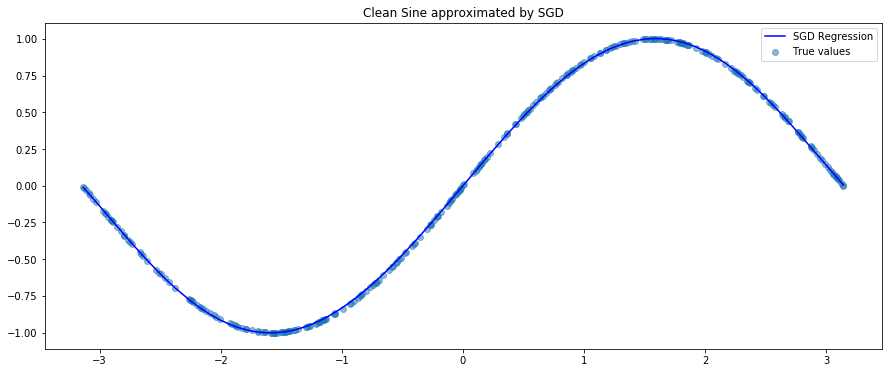

In [38]:
# Standardize the polynomial features for SGD
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Building and training the SGD model
sgd_model = SGDRegressor(max_iter=100_000, # I used sufficient itterations to approach global min
                        learning_rate = 'adaptive', # addaptive learning rate to avoid divergence
                        eta0=0.1, # initial learning rate
                        random_state=1776)

# Fitting the model
sgd_model.fit(X_train_poly_scaled, y_train.values.ravel())

# Predicting on the test set
sgd_y_pred = sgd_model.predict(X_test_poly_scaled)

# Plotting the results
plt.figure(figsize = (15,6))
plt.scatter(X_test, y_test, label='True values', alpha=0.5)
plt.plot(sorted(X_test.values.flatten()),
        [pred for _, pred in sorted(zip(X_test.values.flatten(), sgd_y_pred))],
        color='blue',
        label='SGD Regression')
plt.title('Clean Sine approximated by SGD')
plt.legend()
plt.show()


2)

### I will use a low pass filter to filter out the high frequency components of the noisy sine wave. Below I will construct a function that takes in the series, sampling frequency (length of series), cutoff frequency, and filter order. I will search over a grid of parameters to identify the best params.

In [13]:
def low_pass_filter(data, cutoff, fs, order):
    """
    Low-pass Butterworth filter 
    
    Parameters:
    - data (array): The input signal to be filtered.
    - cutoff (float): The cutoff frequency of the low-pass filter in Hertz.
    - fs (float): The sampling frequency of the input signal in Hertz.
    - order (int): The order of the Butterworth filter.
    
    Returns:
    - y (array): The filtered signal.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

MSE = 100

for i in range(1, 30):
    for j in range(1, 4):

        fs = noisySine.shape[0]  # Sampling frequency
        cutoff = i  # Cutoff frequency
        order = j  # Filter order
        filtered_sine = low_pass_filter(noisySine.values.flatten(), cutoff, fs, order)

        # Calculate and report the error
        error = np.mean((filtered_sine - cleansine.values.flatten()) ** 2)

        if error < MSE:
            MSE = error
            print(f'Mean Squared Error: {np.round(error, 6)},  cutoff = {i}, order = {j}')

Mean Squared Error: 0.090654,  cutoff = 1, order = 1
Mean Squared Error: 0.020006,  cutoff = 2, order = 1
Mean Squared Error: 0.019544,  cutoff = 2, order = 2
Mean Squared Error: 0.006254,  cutoff = 3, order = 1
Mean Squared Error: 0.005333,  cutoff = 3, order = 2
Mean Squared Error: 0.002524,  cutoff = 4, order = 1
Mean Squared Error: 0.002081,  cutoff = 4, order = 2
Mean Squared Error: 0.001228,  cutoff = 5, order = 1
Mean Squared Error: 0.001003,  cutoff = 5, order = 2
Mean Squared Error: 0.000697,  cutoff = 6, order = 1
Mean Squared Error: 0.000561,  cutoff = 6, order = 2
Mean Squared Error: 0.000455,  cutoff = 7, order = 1
Mean Squared Error: 0.000367,  cutoff = 7, order = 2
Mean Squared Error: 0.000339,  cutoff = 8, order = 1
Mean Squared Error: 0.000286,  cutoff = 8, order = 2
Mean Squared Error: 0.000283,  cutoff = 9, order = 1
Mean Squared Error: 0.000257,  cutoff = 9, order = 2
Mean Squared Error: 0.000253,  cutoff = 10, order = 2
Mean Squared Error: 0.000253,  cutoff = 11, o

### It appears that the best cutoff is 11, and the best order is 1. So I preceed using those parameters in my low pass filter.

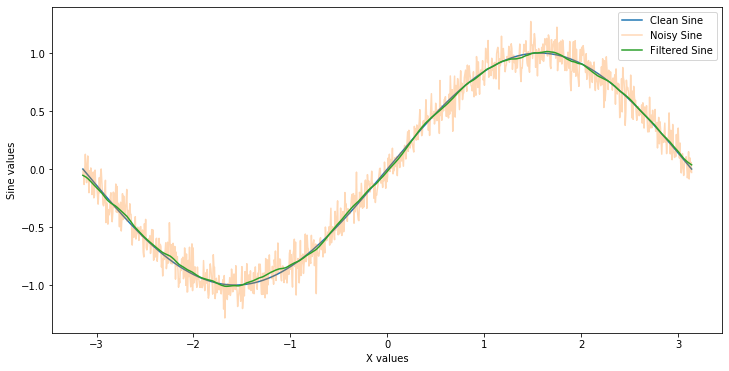

Mean Squared Error: 0.0002527335316080625


In [14]:
# inputting the optimal parameters
fs = noisySine.shape[0] 
cutoff = 11  
order = 1 
filtered_sine = low_pass_filter(noisySine.values.flatten(), cutoff, fs, order)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(xvalsSine, cleansine, label='Clean Sine')
plt.plot(xvalsSine, noisySine, label='Noisy Sine', alpha = 0.3)
plt.plot(xvalsSine, filtered_sine, label='Filtered Sine')
plt.xlabel('X values')
plt.ylabel('Sine values')
plt.legend()
plt.show()

# Calculate and report the error
error = np.mean((filtered_sine - cleansine.values.flatten()) ** 2)
print(f'Mean Squared Error: {error}')


### Depicted above is the noisy sine wave sent through the optimized low pass filter, in comparison to the noisy sine wave, and the clean sine wave. As depicted above the mean square error is 0.000253

## Question 3:

Time series with pi
-----------------------
Attached is a function genPiAppxDigits(numdigits,appxAcc) which returns an approximate value of pi
to numdigits digits of accuracy. appxAcc is an integer that controls the approximation accuracy, with
a larger number for appxAcc leading to a better approximation.
i) Fix numdigits and appxAcc to be sufficiently large, say 1000 and 100000 respectively.
Treat each of the 1000 resulting digits of pi as the value of a time series. Thus x[n]=nth digit
of pi for n=1,1000. Build a simple time series forecasting model (any model of your choice)
that predicts the next 50 digits of pi. Report your accuracy. Using your results, can
you conclude that pi is irrational? If so, how?
(bonus) Now let's vary appxAcc to be 1000,5000,10000,50000,100000 with fixed numdigits=1000. You thus
have 5 time series, each corresponding to a value of appxAcc. Can you find the pairwise correlation
between each of the time series?

#
def genPiAppxDigits(numdigits,appxAcc):
	import numpy as np
	from decimal import getcontext, Decimal
	getcontext().prec = numdigits
	mypi = (Decimal(4) * sum(-Decimal(k%4 - 2) / k for k in range(1, 2*appxAcc+1, 2)))
	return mypi

In [17]:
# Setting params accrding to instructions
numdigits = 1_000
appxAcc = 100_000

In [18]:
# Given function 
def genPiAppxDigits(numdigits,appxAcc):
	import numpy as np
	from decimal import getcontext, Decimal
	getcontext().prec = numdigits
	mypi = (Decimal(4) * sum(-Decimal(k%4 - 2) / k for k in range(1, 2*appxAcc+1, 2)))
	return mypi

In [19]:
# Getting the first 1000 digits
pi_digits = genPiAppxDigits(numdigits, appxAcc)

# Converting to string to loop through and convert to int 
pi_digits_str = str(pi_digits).replace(".", "")

# Convert the string of digits to a numpy array of integers
pi_digits_arr = np.array([int(digit) for digit in pi_digits_str])

In [20]:
# Split 95-5
train = pi_digits_arr[:950]
test = pi_digits_arr[950:]

# Train an auto_arima 
model = auto_arima(train,
                    seasonal=False,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

# Make predictions
predictions = model.predict(n_periods=50)

# Constraining the output to be integers
def constrain_output(predictions):
    # Constrain the output to integers 0-9
    predictions = np.round(predictions).clip(0, 9).astype(int)
    return predictions

# Applying the constraining function
predictions = constrain_output(predictions)

# Calculate the MSE
mse = mean_squared_error(test, predictions)
print('Mean Squared Error:', mse)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5915.186, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5229.941, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5568.710, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5054.844, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4946.806, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4858.125, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4829.277, Time=0.10 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4689.974, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4688.265, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4693.439, Time=0.17 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4690.030, Time=0.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4690.4

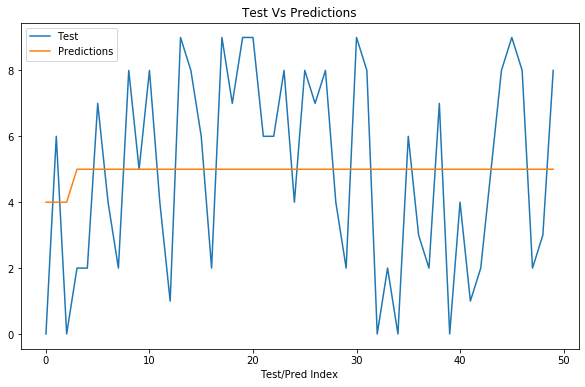

In [21]:
plt.figure(figsize = (10, 6))
plt.plot(test, label = 'Test')
plt.plot(predictions, label = 'Predictions')
plt.title('Test Vs Predictions')
plt.legend()
plt.xlabel('Test/Pred Index')
plt.show()

### Answer: Based upon the relatively high MSE and the inability for the forecasting algorithm to predict articulations in the test set, it seems plausible that the digits of pi are irrational. Although, I cannot prove the irrationality of pi through this method, it certainly goes to show the uncertainty in the coming numbers of pi.

In [22]:
# Accuracies outlined in the problem
appxAcc_values = [1_000, 5_000, 10_000, 50_000, 100_000]
time_series = []

# Generate series for each appxAcc values
for appxAcc in appxAcc_values:
    pi_digits = genPiAppxDigits(numdigits, appxAcc)
    pi_digits_str = str(pi_digits).replace(".", "")
    time_series.append(np.array([int(digit) for digit in pi_digits_str]))

# Calculate the pairwise correlation
correlations = np.zeros((5, 5))

# Loop through the matrix and fill out row/col
for i in range(5):
    for j in range(5):
        # ith row jth col corr
        corr, _ = pearsonr(time_series[i], time_series[j])
        correlations[i, j] = corr

print('Pairwise correlation matrix:')
correlations


Pairwise correlation matrix:


array([[ 1.        ,  0.05107241, -0.01748925,  0.02906733,  0.06188769],
       [ 0.05107241,  1.        , -0.02581177, -0.00205588,  0.00718532],
       [-0.01748925, -0.02581177,  1.        , -0.03685617,  0.08276424],
       [ 0.02906733, -0.00205588, -0.03685617,  1.        , -0.01975425],
       [ 0.06188769,  0.00718532,  0.08276424, -0.01975425,  1.        ]])

### I expected the higher appxAcc values to correlate to the other higher appxAcc valeus more highly, but this does not seem to be the case. This potential shows the volitility of the function itself.